# **Importing Libraries**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import array
import gzip
import os
from os import path
import struct
import urllib
import matplotlib.pyplot as plt
import time
import numpy.random as nr
from jax.api import jit, grad
from jax.config import config
from jax.scipy.special import logsumexp
import jax.numpy as np





# **Loading Data**

In [0]:
"""The code for loading data has been taken entirely from this github repository-
https://github.com/google/jax/tree/master/examples """

In [0]:
_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
  """Create a one-hot encoding of x of size k."""
  return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return np.array(array.array("B", fh.read()), dtype=np.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return np.array(array.array("B", fh.read()),
                      dtype=np.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / np.float32(255.)
  test_images = _partial_flatten(test_images) / np.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if permute_train:
    perm = np.random.RandomState(0).permutation(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]

  return train_images, train_labels, test_images, test_labels

# **Defining Functions**

In [0]:
rng = nr.RandomState(0)

In [0]:
def init_params(layer_sizes):
  return [(rng.randn(m, n), rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

In [0]:
def predict(params, input):
  activations = input
  for w, b in params[:-1]:
    output = np.dot(activations, w) + b
    activations = np.tanh(output)

  final_w, final_b = params[-1]
  logits = np.dot(activations, final_w) + final_b
  return logits - logsumexp(logits, axis=1, keepdims=True)

In [0]:
def loss(params, batch):
  inputs, targets = batch
  preds = predict(params, inputs)
  return -np.mean(np.sum(preds * targets, axis=1))

In [0]:
def accuracy(params, batch):
  inputs, targets = batch
  target_class = np.argmax(targets, axis=1)
  predicted_class = np.argmax(predict(params, inputs), axis=1)
  return np.mean(predicted_class == target_class)

# **Hyperparameters and Training data batches**

In [0]:
layer_sizes = [784, 1024, 1024, 10]
lr = 0.001
num_epochs = 20
batch_size = 32

In [0]:
train_images, train_labels, test_images, test_labels = mnist()
num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

In [0]:
def train_data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]
      yield train_images[batch_idx], train_labels[batch_idx]
train_batches = train_data_stream()

# **Training**

**Simple Gradient Descent**

Epoch number 1

Training set accuracy = 0.8428000211715698
Test set accuracy = 0.8391000628471375

Epoch number 2

Training set accuracy = 0.8785666823387146
Test set accuracy = 0.8671000599861145

Epoch number 3

Training set accuracy = 0.8946499824523926
Test set accuracy = 0.8813000321388245

Epoch number 4

Training set accuracy = 0.907200038433075
Test set accuracy = 0.8883000612258911

Epoch number 5

Training set accuracy = 0.9187333583831787
Test set accuracy = 0.897100031375885

Epoch number 6

Training set accuracy = 0.9255666732788086
Test set accuracy = 0.9044000506401062

Epoch number 7

Training set accuracy = 0.9328500032424927
Test set accuracy = 0.90420001745224

Epoch number 8

Training set accuracy = 0.9363666772842407
Test set accuracy = 0.9066000580787659

Epoch number 9

Training set accuracy = 0.9429666996002197
Test set accuracy = 0.909000039100647

Epoch number 10

Training set accuracy = 0.9485166668891907
Test set accuracy = 0.9165000319480896

Epoch number 1

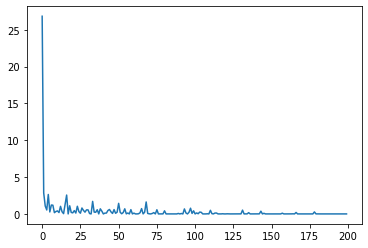

In [147]:
params = init_params(layer_sizes)
track_loss = []
for epoch in range(num_epochs):
  for i in range(num_batches):
    inp = next(batches)
    grads = grad(loss)(params, inp)
    params = [(w - lr*dw, b - lr*db)
            for (w, b), (dw, db) in zip(params, grads)]

    if i%100 == 0:
      track_loss.append(loss(params,inp))
    
  

  train_acc = accuracy(params, (train_images, train_labels))
  test_acc = accuracy(params, (test_images, test_labels))
  print(f'Epoch number {epoch+1}\n')
  print(f'Training set accuracy = {train_acc}')
  print(f'Test set accuracy = {test_acc}\n')

plt.plot(track_loss)

**Momentum**

Epoch number 1

Training set accuracy = 0.8282166719436646
Test set accuracy = 0.829300045967102

Epoch number 2

Training set accuracy = 0.8438833355903625
Test set accuracy = 0.8354000449180603

Epoch number 3

Training set accuracy = 0.8589000105857849
Test set accuracy = 0.8504000306129456

Epoch number 4

Training set accuracy = 0.8982499837875366
Test set accuracy = 0.8904000520706177

Epoch number 5

Training set accuracy = 0.9063166975975037
Test set accuracy = 0.8992000222206116

Epoch number 6

Training set accuracy = 0.9172999858856201
Test set accuracy = 0.906000018119812

Epoch number 7

Training set accuracy = 0.9103833436965942
Test set accuracy = 0.8986000418663025

Epoch number 8

Training set accuracy = 0.9243833422660828
Test set accuracy = 0.9111000299453735

Epoch number 9

Training set accuracy = 0.9265000224113464
Test set accuracy = 0.9154000282287598

Epoch number 10

Training set accuracy = 0.9175333380699158
Test set accuracy = 0.9033000469207764

Epoch numbe

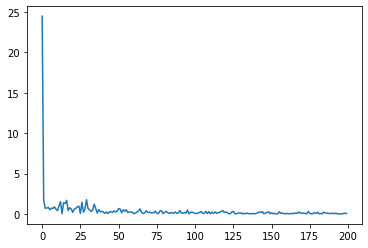

In [148]:
params = init_params(layer_sizes)
gamma = 0.8
track_loss = []
vel = [(np.zeros([m, n]), np.zeros([n]))
        for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

for epoch in range(num_epochs):

  for i in range(num_batches):

    inp = next(batches)
    grads = grad(loss)(params, inp)

    vel = [(gamma * vel_w + lr * dw, gamma * vel_b + lr * db )
           for (vel_w, vel_b), (dw, db) in zip(vel, grads)]

    params = [(w - vel_w, b - vel_b)
            for (w, b), (vel_w, vel_b) in zip(params, vel)]

    if i%100 == 0:
      track_loss.append(loss(params,inp))
    
  

  train_acc = accuracy(params, (train_images, train_labels))
  test_acc = accuracy(params, (test_images, test_labels))
  print(f'Epoch number {epoch+1}\n')
  print(f'Training set accuracy = {train_acc}')
  print(f'Test set accuracy = {test_acc}\n')

plt.plot(track_loss)

**ADAGRAD**

Epoch number 1

Training set accuracy = 0.8704333305358887
Test set accuracy = 0.8601000308990479

Epoch number 2

Training set accuracy = 0.901283323764801
Test set accuracy = 0.8808000683784485

Epoch number 3

Training set accuracy = 0.9193000197410583
Test set accuracy = 0.8977000713348389

Epoch number 4

Training set accuracy = 0.9360499978065491
Test set accuracy = 0.9091000556945801

Epoch number 5

Training set accuracy = 0.9422333240509033
Test set accuracy = 0.9124000668525696

Epoch number 6

Training set accuracy = 0.9505833387374878
Test set accuracy = 0.9131000638008118

Epoch number 7

Training set accuracy = 0.9572666883468628
Test set accuracy = 0.9153000712394714

Epoch number 8

Training set accuracy = 0.9670166969299316
Test set accuracy = 0.917900025844574

Epoch number 9

Training set accuracy = 0.9720333218574524
Test set accuracy = 0.9130000472068787

Epoch number 10

Training set accuracy = 0.9791833162307739
Test set accuracy = 0.92330002784729

Epoch number 

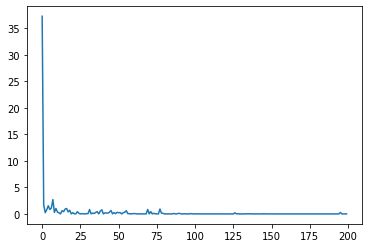

In [149]:
params = init_params(layer_sizes)
eps = 1e-4
track_loss = []
vel = [(np.zeros([m, n]), np.zeros([n]))
        for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

for epoch in range(num_epochs):

  for i in range(num_batches):

    inp = next(batches)
    grads = grad(loss)(params, inp)

    vel = [(vel_w + dw**2, vel_b + db**2 )
           for (vel_w, vel_b), (dw, db) in zip(vel, grads)]

    params = [(w - dw*lr/(vel_w**0.5 + eps), b - db*lr/(vel_b**0.5 + eps))
            for (w, b), (vel_w, vel_b),(dw,db) in zip(params, vel,grads)]

    if i%100 == 0:
      track_loss.append(loss(params,inp))
    
  

  train_acc = accuracy(params, (train_images, train_labels))
  test_acc = accuracy(params, (test_images, test_labels))
  print(f'Epoch number {epoch+1}\n')
  print(f'Training set accuracy = {train_acc}')
  print(f'Test set accuracy = {test_acc}\n')

plt.plot(track_loss)

# **RMSProp**

Epoch number 1

Training set accuracy = 0.8531833291053772
Test set accuracy = 0.851300060749054

Epoch number 2

Training set accuracy = 0.8773666620254517
Test set accuracy = 0.8765000700950623

Epoch number 3

Training set accuracy = 0.891700029373169
Test set accuracy = 0.8880000710487366

Epoch number 4

Training set accuracy = 0.8809000253677368
Test set accuracy = 0.8753000497817993

Epoch number 5

Training set accuracy = 0.9083333611488342
Test set accuracy = 0.9063000679016113

Epoch number 6

Training set accuracy = 0.8868666887283325
Test set accuracy = 0.8867000341415405

Epoch number 7

Training set accuracy = 0.9024500250816345
Test set accuracy = 0.898300051689148

Epoch number 8

Training set accuracy = 0.9099000096321106
Test set accuracy = 0.9049000144004822

Epoch number 9

Training set accuracy = 0.8996166586875916
Test set accuracy = 0.8929000496864319

Epoch number 10

Training set accuracy = 0.8936833143234253
Test set accuracy = 0.8888000249862671

Epoch number

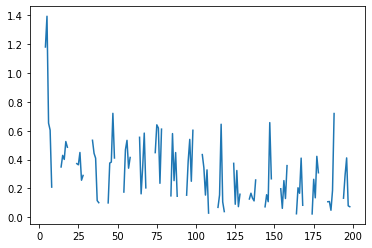

In [166]:
params = init_params(layer_sizes)
eps = 1e-4
beta = 0.9
track_loss = []
vel = [(np.zeros([m, n]), np.zeros([n]))
        for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

for epoch in range(num_epochs):

  for i in range(num_batches):

    inp = next(batches)
    grads = grad(loss)(params, inp)

    vel = [(beta*vel_w + (1-beta)*dw**2, beta*vel_b + (1-beta)*db**2 )
           for (vel_w, vel_b), (dw, db) in zip(vel, grads)]

    params = [(w - dw*lr/(vel_w**0.5 + eps), b - db*lr/(vel_b**0.5 + eps))
            for (w, b), (vel_w, vel_b),(dw,db) in zip(params, vel,grads)]

    if i%100 == 0:
      track_loss.append(loss(params,inp))
    
  

  train_acc = accuracy(params, (train_images, train_labels))
  test_acc = accuracy(params, (test_images, test_labels))
  print(f'Epoch number {epoch+1}\n')
  print(f'Training set accuracy = {train_acc}')
  print(f'Test set accuracy = {test_acc}\n')

plt.plot(track_loss)

# **ADAM**

Epoch number 1

Training set accuracy = 0.8227500319480896
Test set accuracy = 0.8142000436782837

Epoch number 2

Training set accuracy = 0.8662166595458984
Test set accuracy = 0.8542000651359558

Epoch number 3

Training set accuracy = 0.888450026512146
Test set accuracy = 0.8705000281333923

Epoch number 4

Training set accuracy = 0.8993333578109741
Test set accuracy = 0.8835000395774841

Epoch number 5

Training set accuracy = 0.905750036239624
Test set accuracy = 0.8891000151634216

Epoch number 6

Training set accuracy = 0.9149333238601685
Test set accuracy = 0.8978000283241272

Epoch number 7

Training set accuracy = 0.9152166843414307
Test set accuracy = 0.8968000411987305

Epoch number 8

Training set accuracy = 0.9217166900634766
Test set accuracy = 0.90420001745224

Epoch number 9

Training set accuracy = 0.926466703414917
Test set accuracy = 0.909000039100647

Epoch number 10

Training set accuracy = 0.9317333698272705
Test set accuracy = 0.9125000238418579

Epoch number 11

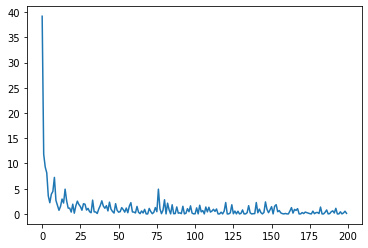

In [171]:
params = init_params(layer_sizes)
eps = 1e-4
beta1 = 0.9
beta2 = 0.9
track_loss = []

vel = [(np.zeros([m, n]), np.zeros([n]))
        for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

mom = [(np.zeros([m, n]), np.zeros([n]))
        for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

for epoch in range(num_epochs):

  for i in range(num_batches):

    inp = next(batches)
    grads = grad(loss)(params, inp)

    mom = [(beta1*mom_w + (1-beta1)*dw, beta1*mom_b + (1-beta1)*db )
           for (mom_w, mom_b), (dw, db) in zip(mom, grads)]

    vel = [(beta2*vel_w + (1-beta2)*dw**2, beta2*vel_b + (1-beta2)*db**2 )
           for (vel_w, vel_b), (dw, db) in zip(vel, grads)]

    params = [(w - mom_w*lr/(vel_w**0.5 + eps), b - mom_b*lr/(vel_b**0.5 + eps))
            for (w, b), (vel_w, vel_b),(mom_w,mom_b) in zip(params, vel,mom)]

    if i%100 == 0:
      track_loss.append(loss(params,inp))
    
  

  train_acc = accuracy(params, (train_images, train_labels))
  test_acc = accuracy(params, (test_images, test_labels))
  print(f'Epoch number {epoch+1}\n')
  print(f'Training set accuracy = {train_acc}')
  print(f'Test set accuracy = {test_acc}\n')

plt.plot(track_loss)